# Simple MNIST NN from Scratch

In this notebook, I implemented a simple two-layer neural network, from scratch, using only Numpy and Maths, and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Dataset : [Digit Recognizer | Kaggle](https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv)

Made by : Ahmed NANI - [LinkedIn](https://www.linkedin.com/in/nani-ahmed/) - [Github](https://github.com/AhmedN11) - <a href='mailto:ahmednani015@gmail.com'>ahmednani015@gmail.com</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(threshold = 10)

In [2]:
data = pd.read_csv('train.csv')
data.shape

(42000, 785)

In [3]:
data = np.array(data)
m, n = data.shape
train, test = data[:40000].T, data[40000:].T

X_train = train[1:] / 255
y_train = train[0]

X_test = test[1:] / 255
y_test = test[0]

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [4]:
def ReLU(x):
    return np.maximum(0, x)

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))
    return A

def one_hot(x):
    one_hot_Y = np.zeros((x.size, x.max() + 1))
    one_hot_Y[np.arange(x.size), x] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def ReLU_Deriv(x):
    return x > 0

def get_predictions(x):
    return np.argmax(x, 0)

def get_accuracy(predictions, Y):
#     print(predictions, Y)
    return 'Accuracy : ' + str(np.sum(predictions == Y) / Y.size)

## Let's build a neural network from the ground up!

In [5]:
class NeuralNet:
    
    def __init__(self):
        self.W1 = np.random.rand(10, 784) - 0.5
        self.b1 = np.random.rand(10, 1) - 0.5
        self.W2 = np.random.rand(10, 10) - 0.5
        self.b2 = np.random.rand(10, 1) - 0.5
        return
        
    def forward_prop(self, X):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = ReLU(self.Z1)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = softmax(self.Z2)
        return self.Z1, self.A1, self.Z2, self.A2
    
    def back_prop(self, X, y):
        one_hot_y = one_hot(y)
        self.dZ2 = self.A2 - one_hot_y
        self.dW2 = 1/m * self.dZ2.dot(self.A1.T)
        self.db2 = 1/m * np.sum(self.dZ2, axis = 1)
        self.dZ1 = self.W2.T.dot(self.dZ2) * ReLU_Deriv(self.Z1)
        self.dW1 = 1/m * self.dZ1.dot(X.T)
        self.db1 = 1/m * np.sum(self.dZ1, axis = 1)
        return self.dW2, self.db2, self.dW1, self.db1

    def update_params(self, learning_rate):
        self.W1 = self.W1 - learning_rate * self.dW1
        self.b1 = self.b1 - learning_rate * self.db1.reshape(-1,1)
        self.W2 = self.W2 - learning_rate * self.dW2
        self.b2 = self.b2 - learning_rate * self.db2.reshape(-1,1)
        return self.W1, self.b1, self.W2, self.b2
    
    def fit(self, X, y, epochs = 500, learning_rate = 0.1):
#         W1, b1, W2, b2 = self.init_args()
        for _ in range(epochs) :
            _ += 1
            self.Z1, self.A1, self.Z2, self.A2 = self.forward_prop(X)
            self.dW2, db2, dW1, db1 = self.back_prop(X, y)
            self.W1, self.b1, self.W2, self.b2 = self.update_params(0.1)
            if _ % 10 == 0 :
                print('Iteration : ' + str (_))
                print(get_accuracy(get_predictions(self.A2), y))
        return
    
    def evaluate(self, X, y):
        _, _, _, self.A2 = self.forward_prop(X)
        print(get_accuracy(get_predictions(self.A2), y))
    
    def predict(self, x):
        _, _, _, A2 = self.forward_prop(x)
        prediction = get_predictions(A2)
        return prediction[0]

### We can proceed to train the model now :

In [6]:
nn = NeuralNet()
nn.fit(X_train, y_train)

Iteration : 10
Accuracy : 0.14715
Iteration : 20
Accuracy : 0.258575
Iteration : 30
Accuracy : 0.344575
Iteration : 40
Accuracy : 0.4164
Iteration : 50
Accuracy : 0.47765
Iteration : 60
Accuracy : 0.534175
Iteration : 70
Accuracy : 0.578675
Iteration : 80
Accuracy : 0.61495
Iteration : 90
Accuracy : 0.64355
Iteration : 100
Accuracy : 0.667525
Iteration : 110
Accuracy : 0.68605
Iteration : 120
Accuracy : 0.702025
Iteration : 130
Accuracy : 0.715825
Iteration : 140
Accuracy : 0.72745
Iteration : 150
Accuracy : 0.7379
Iteration : 160
Accuracy : 0.7467
Iteration : 170
Accuracy : 0.75515
Iteration : 180
Accuracy : 0.7629
Iteration : 190
Accuracy : 0.77015
Iteration : 200
Accuracy : 0.77595
Iteration : 210
Accuracy : 0.7825
Iteration : 220
Accuracy : 0.7872
Iteration : 230
Accuracy : 0.79125
Iteration : 240
Accuracy : 0.796175
Iteration : 250
Accuracy : 0.800325
Iteration : 260
Accuracy : 0.80465
Iteration : 270
Accuracy : 0.8086
Iteration : 280
Accuracy : 0.8123
Iteration : 290
Accuracy : 0

#### Finally, let's find the accuracy on the test set:

In [7]:
nn.evaluate(X_test, y_test)

Accuracy : 0.847


**84% accuracy, our model generalized from the training data pretty well.**

In [8]:
def make_predictions(X):
    _, _, _, A2 = nn.forward_prop(X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None])
    label = y_train[index]
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
    print("Label : ", label)
    print("Prediction : ", prediction[0])

## Let's test a prediction

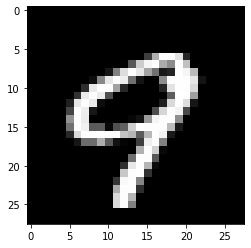

Label :  9
Prediction :  9


In [9]:
test_prediction(100)